## Installations 

In [3]:
!pip install contractions -q
!pip install wordcloud


## Imports 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
from wordcloud import WordCloud
import nltk
from collections import Counter
import contractions
from tqdm import tqdm


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from nltk.corpus import stopwords

# Assuming you already have `df` (combined Fake and Real data)
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to C:\Users\HP/nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [5]:
# Load datasets
fake_df = pd.read_csv(r"C:\Users\HP\Documents\FAke News Classifier\Fake.csv")
real_df = pd.read_csv(r"C:\Users\HP\Documents\FAke News Classifier\True.csv")

In [6]:
fake_df['label'] = 0
real_df['label'] = 1


df = pd.concat([fake_df, real_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Combine title and text
df['combined_text'] = df['title'] + " " + df['text']

In [7]:
def clean_text(text):
    text = contractions.fix(text)                         # Expand contractions
    text = text.encode("ascii", errors="ignore").decode() # Remove non-ASCII chars
    text = text.lower()                                   # Lowercase
    text = re.sub(r"http\S+|www.\S+", "", text)           # Remove URLs
    text = re.sub(r"<.*?>", "", text)                     # Remove HTML tags
    text = re.sub(r"[^a-z\s]", "", text)                  # Keep only letters and spaces
    text = re.sub(r"\b\w{1}\b", "", text)                 # Remove single-letter words
    text = re.sub(r"\s+", " ", text).strip()  
# Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

In [8]:
df['clean_text'] = df['combined_text'].apply(clean_text)
df[['clean_text', 'label']].head()

,clean_text,label
0,ben stein calls th circuit court committed cou...,0
1,trump drops steve bannon national security cou...,1
2,puerto rico expects yous lift jones act shippi...,1
3,oops trump accidentally confirmed leaked israe...,0
4,donald trump heads scotland reopen golf resort...,1


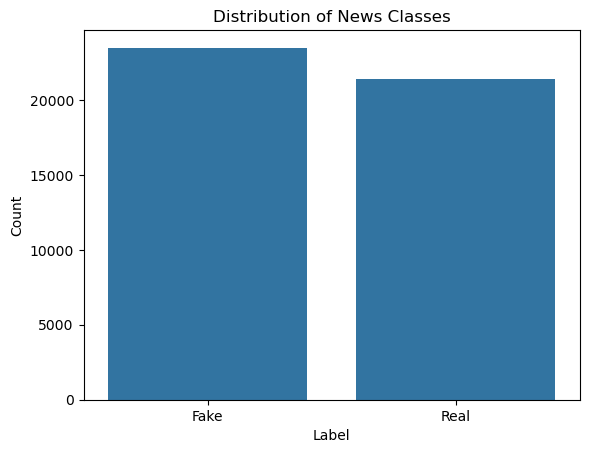

In [9]:
sns.countplot(x="label", data=df)
plt.xticks([0, 1], ["Fake", "Real"])
plt.title("Distribution of News Classes")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

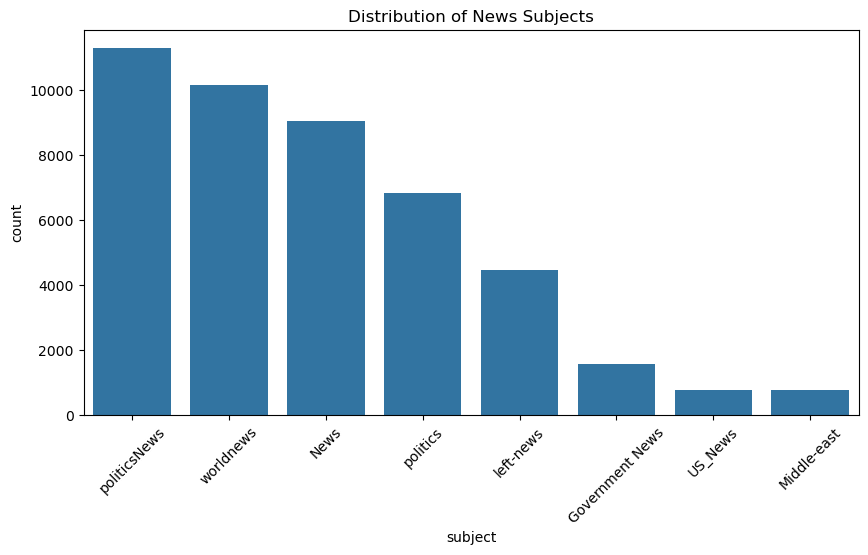

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="subject", order=df["subject"].value_counts().index)
plt.title("Distribution of News Subjects")
plt.xticks(rotation=45)
plt.show()

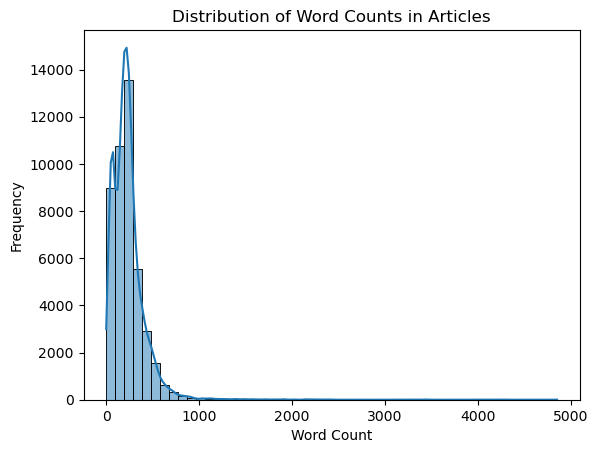

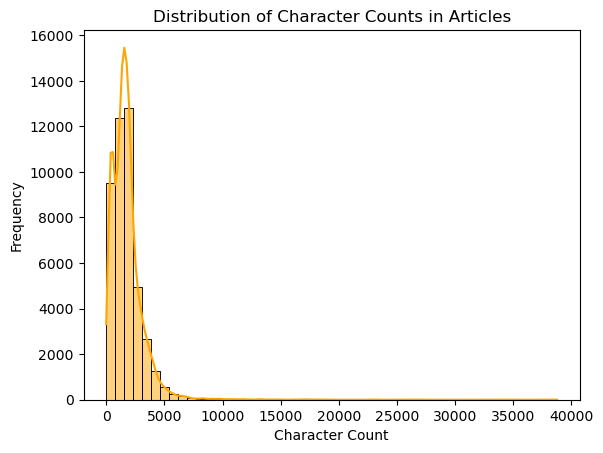

In [11]:
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))
df["char_length"] = df["clean_text"].apply(len)

# Word count
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribution of Word Counts in Articles")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Character count
sns.histplot(df["char_length"], bins=50, kde=True, color='orange')
plt.title("Distribution of Character Counts in Articles")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()


In [12]:
df

,title,text,subject,date,label,combined_text,clean_text,text_length,char_length
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein calls th circuit court committed cou...,109,802
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1,Trump drops Steve Bannon from National Securit...,trump drops steve bannon national security cou...,472,3613
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects yous lift jones act shippi...,182,1347
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump accidentally confirmed leaked israe...,114,943
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1,Donald Trump heads for Scotland to reopen a go...,donald trump heads scotland reopen golf resort...,305,2278
...,...,...,...,...,...,...,...,...,...
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,,politics,"Mar 27, 2017",0,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,unreal cbss ted koppel tells sean hannity bad ...,10,59
44894,PM May seeks to ease Japan's Brexit fears duri...,LONDON/TOKYO (Reuters) - British Prime Ministe...,worldnews,"August 29, 2017",1,PM May seeks to ease Japan's Brexit fears duri...,pm may seeks ease japans brexit fears trade vi...,429,3224
44895,Merkel: Difficult German coalition talks can r...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,worldnews,"November 16, 2017",1,Merkel: Difficult German coalition talks can r...,merkel difficult german coalition talks reach ...,45,341
44896,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,News,"July 14, 2017",0,Trump Stole An Idea From North Korean Propaga...,trump stole idea north korean propaganda parod...,480,3279


## Text Tokenization 


In [14]:
tokenized_texts = [text.split() for text in df['clean_text']]

In [15]:
# Build vocabulary
word_counter = Counter(word for tokens in tokenized_texts for word in tokens)
vocab_size = 10000  # Limit vocab size
most_common = word_counter.most_common(vocab_size - 2)

In [16]:
# Create word-to-index mappings
word2idx = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1
idx2word = {idx: word for word, idx in word2idx.items()}

## Dataset Preparation

In [17]:
# Function to convert tokens to indices
def encode(tokens, word2idx, max_len):
    ids = [word2idx.get(word, word2idx["<UNK>"]) for word in tokens]
    if len(ids) < max_len:
        ids += [word2idx["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

In [18]:
max_len = 300
encoded_texts = [encode(tokens, word2idx, max_len) for tokens in tokenized_texts]
labels = df['label'].values

In [20]:
# Create the custom dataset
class NewsDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [21]:
# Step 1: First split → train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    encoded_texts, labels, test_size=0.30, random_state=42, stratify=labels
)

# Step 2: Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [22]:
# Create datasets
train_dataset = NewsDataset(X_train, y_train)
val_dataset   = NewsDataset(X_val, y_val)
test_dataset  = NewsDataset(X_test, y_test)

In [23]:
train_dataset[0]

(tensor([4420, 1918,   39,  516,   35,   88, 9491,  127,   70,    3, 2898,   24,
            8,  413, 1348,  306,   70,    3,  412, 1918,  965,  127,   70,   14,
            3, 3105,  132,    1,    1,  934,    1,  757,  826,   38,  706, 2618,
           19,  318,   86,  115, 2090,   36, 1174,    1, 3299,    3,  909,  353,
          465, 1596,   38, 1334,   32,    1,  350,   27,   34,    1, 6685,  111,
          374,  411,  227,   39,   24,   22,   16, 2678,  432,    5,  750,   64,
            7,   50,  589,  153,   22,   16,    1,    2,   78, 4546,  219,    1,
          295,  560,   56,  476,   55,   90,  997,  182, 3458,   70,    3,  153,
         1549,   58,  412,  757, 3127,   88,   15,    1, 2240,  300, 2017,  135,
          836, 1767,  685, 4673, 3268,  477,  801,    1, 5532,  412, 1711,  709,
           61,   15,  580,  745, 2952,   30,   35,  934,  125,   10,   11, 1091,
          469, 1347,  135,  169, 1217, 2188,  745,    6,  258, 1711,   42,   11,
           15,  685,    1,  

In [24]:
# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, num_layers=1, dropout=0.5, bidirectional=True):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        lstm_out, _ = self.lstm(embedded)  # lstm_out: [batch_size, seq_len, hidden_dim * num_directions]
        # Take last hidden state (can use mean or max pooling too)
        last_hidden = lstm_out[:, -1, :]  # [batch_size, hidden_dim * num_directions]
        out = self.dropout(last_hidden)
        out = self.fc(out)
        return self.sigmoid(out).squeeze()

In [26]:
model = LSTMClassifier(
    vocab_size=len(word2idx),
    embedding_dim=100,
    hidden_dim=128,
    num_layers=1,
    dropout=0.5,
    bidirectional=True
)

## Model Training  

In [60]:
# Loss function
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

In [61]:
# Initialize tracking lists
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct, total = 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

        preds = (outputs >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    avg_train_loss = train_loss / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
         val_loop = tqdm(val_loader, desc="Validation", leave=False)
         for inputs, labels in val_loop:
             inputs, labels = inputs.to(device), labels.to(device)
             outputs = model(inputs)

             loss = criterion(outputs, labels)
             val_loss += loss.item() * inputs.size(0)

             preds = (outputs >= 0.5).float()
             val_correct += (preds == labels).sum().item()
             val_total += labels.size(0)

             val_loop.set_postfix(val_loss=loss.item())

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / val_total
    

    # Epoch summary
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

[Epoch 1] Train Loss: 0.0032 | Train Acc: 0.9994 | Val Loss: 0.0047 | Val Acc: 0.9994


[Epoch 2] Train Loss: 0.0015 | Train Acc: 0.9998 | Val Loss: 0.0021 | Val Acc: 0.9997


[Epoch 3] Train Loss: 0.0005 | Train Acc: 0.9999 | Val Loss: 0.0022 | Val Acc: 0.9991


[Epoch 4] Train Loss: 0.0003 | Train Acc: 1.0000 | Val Loss: 0.0027 | Val Acc: 0.9996


[Epoch 5] Train Loss: 0.0010 | Train Acc: 0.9997 | Val Loss: 0.0041 | Val Acc: 0.9991


[Epoch 6] Train Loss: 0.0214 | Train Acc: 0.9968 | Val Loss: 0.0135 | Val Acc: 0.9966


[Epoch 7] Train Loss: 0.0033 | Train Acc: 0.9993 | Val Loss: 0.0051 | Val Acc: 0.9982


[Epoch 8] Train Loss: 0.0053 | Train Acc: 0.9990 | Val Loss: 0.0128 | Val Acc: 0.9972


[Epoch 9] Train Loss: 0.0032 | Train Acc: 0.9996 | Val Loss: 0.0122 | Val Acc: 0.9973


[Epoch 10] Train Loss: 0.0017 | Train Acc: 0.9997 | Val Loss: 0.0112 | Val Acc: 0.9978


## Model evaluation 

In [46]:
def evaluate_model(model, dataloader, device, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)  # Add this
            preds = (probs >= 0.5).float()  # Use probability to threshold

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute evaluation metrics
    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec  = recall_score(all_labels, all_preds)
    f1   = f1_score(all_labels, all_preds)

    print(f"Evaluation Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
     # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

Evaluation Metrics:
Accuracy : 0.9976
Precision: 0.9969
Recall   : 0.9981
F1 Score : 0.9975


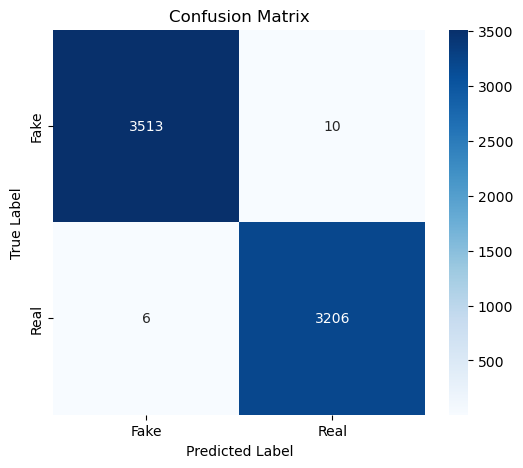

In [63]:
evaluate_model(model, test_loader, device)

In [65]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (outputs >= 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

for i in range(5):
    print(f"Text: {df.iloc[i]['text'][:100]}...")  # or 'title' if you're using headlines
    print(f"Predicted: {int(all_preds[i])}, Actual: {int(all_labels[i])}\n")



Text: 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Holl...
Predicted: 0, Actual: 0

Text: WASHINGTON (Reuters) - U.S. President Donald Trump removed his chief strategist Steve Bannon from th...
Predicted: 0, Actual: 0

Text: (Reuters) - Puerto Rico Governor Ricardo Rossello said on Wednesday he expected the federal governme...
Predicted: 1, Actual: 1

Text: On Monday, Donald Trump once again embarrassed himself and his country by accidentally revealing the...
Predicted: 1, Actual: 1

Text: GLASGOW, Scotland (Reuters) - Most U.S. presidential candidates go abroad to sharpen their foreign p...
Predicted: 0, Actual: 0

